In [1]:
import pandas as pd
from typing import List, Tuple
import numpy as np

from cerberus_builder import build_cerberus, train_cerberus
from preprocess import create_min_max_df, scale_data, downsample_timeseries_data, slice_timeseries_data, masked_expand
from postprocess import generate_predictions

In [2]:
# Example usage:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'], 
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
df = df.iloc[:10000,:]
context_windows = ['1H', '2H', '6H']
context_sizes = [24, 12, 6]
call_window = '10T'
call_size = 24
response_window = '10T'
response_size = 8
call_feature_index = range(0,14)
context_feature_index = [range(0,14),
                        range(0,14),
                        range(0,14)]
response_feature_index = [0, 4, 12]
thresholds = {
    'call': 0.7,
    'response': 0.7,
    'context_0': 0.7,
    'context_1': 0.7,
    'context_2': 0.7
}
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

In [3]:
#Scale Data
min_max_df = create_min_max_df(df)
print(min_max_df)
scaled_df = scale_data(df, min_max_df, feature_range=(0, 1))

                     min      max
p (mbar)          944.58  1005.71
T (degC)          -23.01    12.17
Tpot (K)          250.60   286.73
Tdew (degC)       -25.01     6.91
rh (%)             42.38   100.00
VPmax (mbar)        0.95    14.20
VPact (mbar)        0.79     9.96
VPdef (mbar)        0.00     6.14
sh (g/kg)           0.50     6.30
H2OC (mmol/mol)     0.80    10.08
rho (g/m**3)     1179.43  1383.38
wv (m/s)            0.00    12.96
max. wv (m/s)       0.00    18.38
wd (deg)            0.00   359.90


In [12]:
downsampled_data = downsample_timeseries_data(scaled_df, 
                                        context_windows, 
                                        call_window, 
                                        response_window,
                                        call_feature_index,
                                        context_feature_index,
                                        response_feature_index)
downsampled_data

{'call':                      p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
 2009-01-01 00:10:00  0.849665  0.426094  0.409632     0.504699  0.883721   
 2009-01-01 00:20:00  0.850483  0.415009  0.398838     0.492794  0.885456   
 2009-01-01 00:30:00  0.849828  0.412166  0.396070     0.491855  0.894134   
 2009-01-01 00:40:00  0.849501  0.417851  0.401882     0.499373  0.899341   
 2009-01-01 00:50:00  0.849501  0.418988  0.402712     0.500313  0.897605   
 ...                       ...       ...       ...          ...       ...   
 2009-03-11 10:00:00  0.736300  0.730529  0.721838     0.801692  0.755293   
 2009-03-11 10:10:00  0.738426  0.738772  0.729588     0.810150  0.753558   
 2009-03-11 10:20:00  0.739899  0.758101  0.748132     0.814850  0.699757   
 2009-03-11 10:30:00  0.743661  0.773735  0.762801     0.811717  0.635543   
 2009-03-11 10:40:00  0.746442  0.773167  0.761971     0.802632  0.607775   
 
                      VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh

In [11]:
sliced_data, selected_timestamps = slice_timeseries_data(downsampled_data,
                                    sizes,
                                    thresholds)

sliced_data

{'context_0': array([[[0.87313921, 0.38975744, 0.37129809, ..., 0.063143  ,
          0.08170112, 0.40354265],
         [0.88508097, 0.4112185 , 0.3907187 , ..., 0.10841049,
          0.10564019, 0.90775215],
         [0.89639566, 0.42874739, 0.40631055, ..., 0.03909465,
          0.04769677, 0.61007687],
         ...,
         [0.88276351, 0.52804624, 0.50475136, ..., 0.04938272,
          0.0567646 , 0.50967861],
         [0.87602923, 0.51947129, 0.49737061, ..., 0.05709877,
          0.06809938, 0.48476429],
         [0.87551121, 0.51847641, 0.49644801, ..., 0.05259774,
          0.06701124, 0.57182088]],
 
        [[0.87313921, 0.38975744, 0.37129809, ..., 0.063143  ,
          0.08170112, 0.40354265],
         [0.88508097, 0.4112185 , 0.3907187 , ..., 0.10841049,
          0.10564019, 0.90775215],
         [0.89639566, 0.42874739, 0.40631055, ..., 0.03909465,
          0.04769677, 0.61007687],
         ...,
         [0.88276351, 0.52804624, 0.50475136, ..., 0.04938272,
          0

In [6]:
for key in sliced_data:
    print(sliced_data[key].shape)

(9816, 24, 14)
(9816, 12, 14)
(9816, 6, 14)
(9816, 24, 14)
(9816, 8, 3)


In [7]:
expanded_dict, response_data = masked_expand(sliced_data, sizes)

print(response_data[0,:])
for ir in range(30):
    print(expanded_dict['response'][ir,:,:])
    
for key in expanded_dict:
    print(expanded_dict[key].shape)
    
print(response_data.shape)

[0.87387535 0.93405068 0.11588683]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0.87387535 0.93405068 0.11588683]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.87387535 0.93405068 0.11588683]
 [0.87567479 0.92884415 0.08868335]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.87387535 0.93405068 0.11588683]
 [0.87567479 0.92884415 0.08868335]
 [0.87632913 0.92884415 0.07508161]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[

24
14
Epoch 1/10
2209/2209 [==============================] - 112s 49ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 2/10
2209/2209 [==============================] - 114s 52ms/step - loss: 9.7232e-04 - val_loss: 0.0018
Epoch 3/10
2209/2209 [==============================] - 115s 52ms/step - loss: 8.9367e-04 - val_loss: 0.0018
Epoch 4/10
2209/2209 [==============================] - 101s 46ms/step - loss: 8.4156e-04 - val_loss: 0.0017
Epoch 5/10
2209/2209 [==============================] - 97s 44ms/step - loss: 7.9494e-04 - val_loss: 0.0017
Epoch 6/10
2209/2209 [==============================] - 98s 44ms/step - loss: 7.5228e-04 - val_loss: 0.0019
Epoch 7/10
2209/2209 [==============================] - 98s 44ms/step - loss: 7.2838e-04 - val_loss: 0.0016
Epoch 8/10
2209/2209 [==============================] - 98s 44ms/step - loss: 7.0638e-04 - val_loss: 0.0018
Epoch 9/10
2209/2209 [==============================] - 97s 44ms/step - loss: 6.8258e-04 - val_loss: 0.0018
Epoch 10/10
2209/2209 

AttributeError: Line2D.set() got an unexpected keyword argument 'abel'

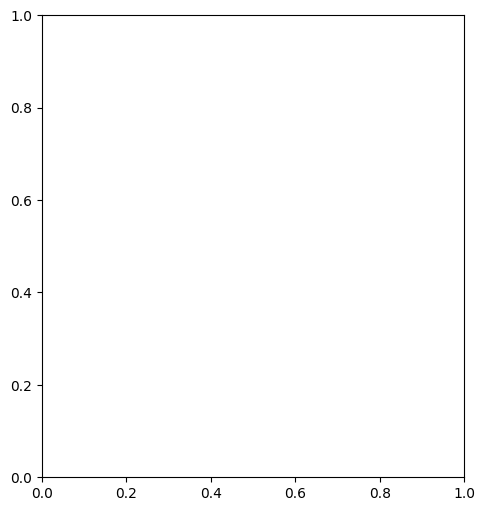

In [8]:
model = build_cerberus(expanded_dict,response_data,64)

model = train_cerberus(model,expanded_dict,response_data,10)

In [9]:
selected_data = {key: value[5000:5001,:] for key, value in sliced_data.items()}
responses_generated = generate_predictions(model,selected_data)
print(selected_data['response'])
print(responses_generated)

1/1 [==============================] - 0s 33ms/step
[[[0.43988222 0.79173898 0.22470076]
  [0.43906429 0.78306144 0.25190424]
  [0.43939146 0.77438389 0.19749728]
  [0.44070015 0.77264839 0.16322089]
  [0.44315393 0.77785491 0.14961915]
  [0.44266318 0.77091288 0.10881393]
  [0.44020939 0.77959042 0.15669206]
  [0.43939146 0.81082957 0.12241567]]]
[[0.42540663 0.7868057  0.18586183]
 [0.4357792  0.789501   0.17619568]
 [0.43561593 0.78981274 0.17437805]
 [0.43495646 0.79338336 0.17243305]
 [0.4345196  0.7966084  0.16963844]
 [0.43920755 0.80122715 0.16332203]
 [0.43962267 0.8039236  0.16421255]
 [0.44004244 0.81759036 0.15814899]]


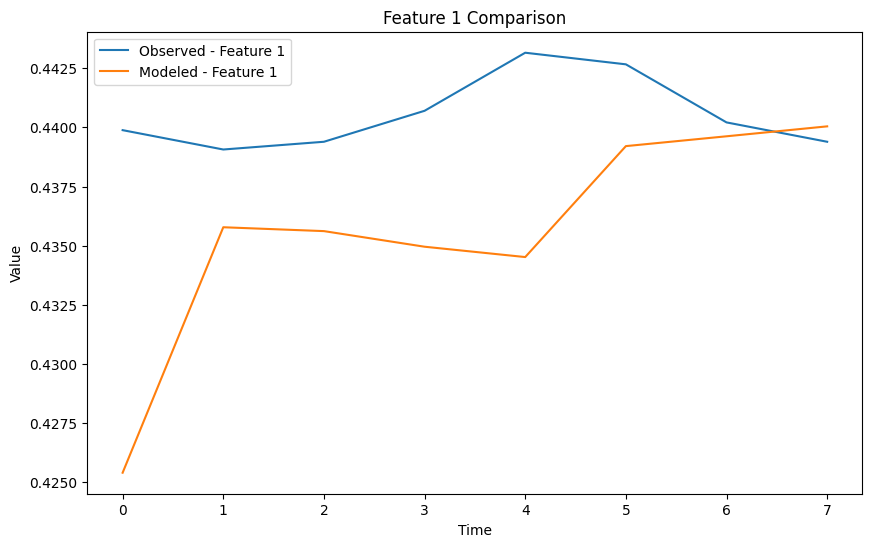

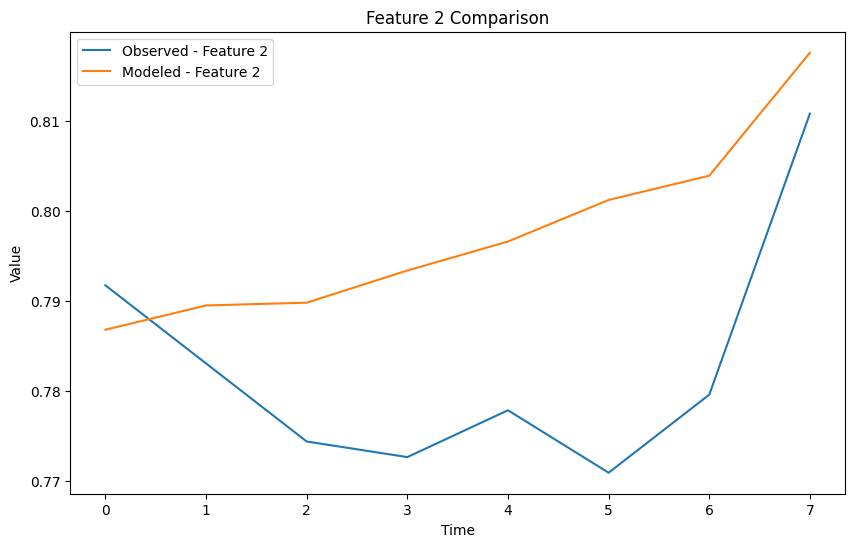

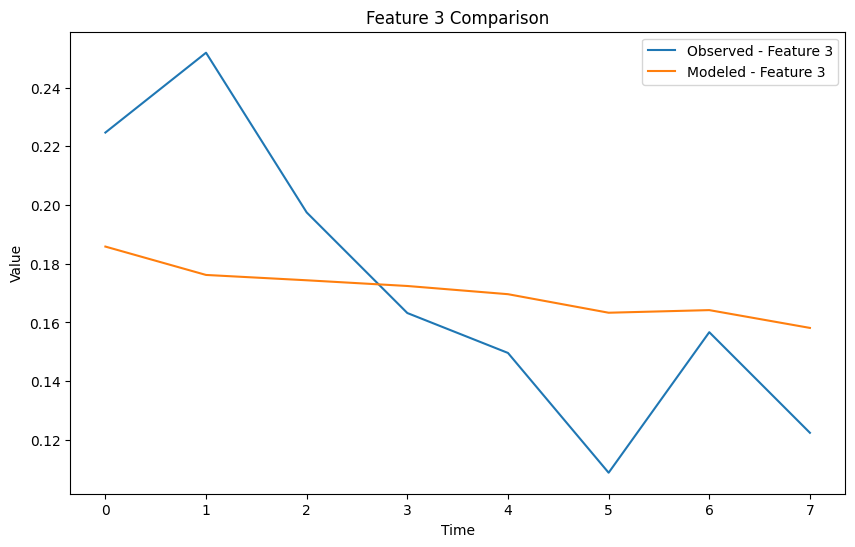

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Example matrices
observed = selected_data['response'][0,:,:]
modeled = responses_generated

# Number of rows and columns
num_rows, num_cols = observed.shape

# Create a plot for each feature (column)
for i in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(observed[:, i], label='Observed - Feature {}'.format(i+1))
    plt.plot(modeled[:, i], label='Modeled - Feature {}'.format(i+1))
    plt.title(f'Feature {i+1} Comparison')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
